# Finance Data OS — Week 1 Notebook
**CSV → Parquet → Validate → Load → Features → Plot → Power BI**

This notebook is a **step-by-step guide** to build your first working pipeline:
- Read a small OHLCV CSV
- Write **Apache Parquet** (partitioned by ticker/year)
- Validate schema with **Pandera**
- Compute simple features
- Quick chart
- Load into Power BI

## ✅ Setup instructions (one time)
Run these in Command Prompt or PowerShell before using the notebook:
```bash
python -m venv .venv
 .venv\Scripts\activate.bat   # (Windows CMD)
pip install pandas pyarrow pandera matplotlib jupyter
```
> Make sure you are using **Python 3.11 (64-bit)** for best compatibility.

In [1]:
from pathlib import Path
import pandas as pd
import glob

print('Python:', sys.version)
print('pandas:', pd.__version__)

Python: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
pandas: 2.2.2


## Step 1 — Create a sample CSV (if you don’t have one yet)

In [2]:
RAW_DIR = Path('raw')
RAW_DIR.mkdir(parents=True, exist_ok=True)
csv_path = RAW_DIR / 'AAPL_daily.csv'

if not csv_path.exists():
    csv_path.write_text(
        'Date,Open,High,Low,Close,Adj Close,Volume\n'
        '2024-12-27,193.11,194.40,192.50,193.60,193.60,46639400\n'
        '2024-12-30,194.00,196.25,193.80,195.95,195.95,38911200\n'
        '2024-12-31,196.10,197.20,195.50,196.75,196.75,35200800\n'
        '2025-01-02,197.00,198.40,196.20,198.10,198.10,41123400\n'
    )
    print('Created sample CSV at', csv_path)
else:
    print('Found existing CSV at', csv_path)

Found existing CSV at raw\AAPL_daily.csv


## Step 2 — Read CSV → DataFrame and enforce types

In [3]:
df = pd.read_csv(csv_path, parse_dates=['Date'])
df = df[['Date','Open','High','Low','Close','Volume']].copy()
df['Ticker'] = 'AAPL'

for c in ['Open','High','Low','Close']:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce').astype('Int64')

df.head()

,Date,Open,High,Low,Close,Volume,Ticker
0,2024-12-27,193.11,194.40,192.5,193.60,46639400,AAPL
1,2024-12-30,194.00,196.25,193.8,195.95,38911200,AAPL
2,2024-12-31,196.10,197.20,195.5,196.75,35200800,AAPL
3,2025-01-02,197.00,198.40,196.2,198.10,41123400,AAPL


## Step 3 — Write partitioned Parquet files

In [4]:
LAKE_DIR = Path('lake/ohlcv')
LAKE_DIR.mkdir(parents=True, exist_ok=True)

df['Year'] = df['Date'].dt.year

for year, g in df.groupby('Year'):
    out_dir = LAKE_DIR / f'ticker=AAPL' / f'year={year}'
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / f'AAPL_{year}.parquet'
    g.drop(columns=['Year']).to_parquet(out_file, engine='pyarrow', index=False)
    print('Wrote', out_file)

Wrote lake\ohlcv\ticker=AAPL\year=2024\AAPL_2024.parquet
Wrote lake\ohlcv\ticker=AAPL\year=2025\AAPL_2025.parquet


## Step 4 — Validate schema with Pandera

In [6]:
import pandera as pa

schema = pa.DataFrameSchema(
    {
        "Date":   pa.Column(pa.DateTime),
        "Ticker": pa.Column(pa.String),
        "Open":   pa.Column(pa.Float),
        "High":   pa.Column(pa.Float),
        "Low":    pa.Column(pa.Float),
        "Close":  pa.Column(pa.Float),
        "Volume": pa.Column(pa.Int64),
    },
    strict=True,  # no extra columns allowed
)

parquet_files = glob.glob('lake/ohlcv/**/*.parquet', recursive=True)
df_test = pd.read_parquet(parquet_files[0])
schema.validate(df_test)

print("✅ Schema validation passed (DataFrameSchema)")
df_test.head()


✅ Schema validation passed (DataFrameSchema)


,Date,Open,High,Low,Close,Volume,Ticker
0,2024-12-27,193.11,194.40,192.5,193.60,46639400,AAPL
1,2024-12-30,194.00,196.25,193.8,195.95,38911200,AAPL
2,2024-12-31,196.10,197.20,195.5,196.75,35200800,AAPL


## Step 5 — Add simple features and save mart file

In [7]:
df_all = pd.concat([pd.read_parquet(p) for p in parquet_files], ignore_index=True)
df_all = df_all.sort_values(['Date'])

df_all['Return1'] = df_all['Close'].pct_change()
df_all['SMA10'] = df_all['Close'].rolling(10, min_periods=1).mean()

MART_DIR = Path('mart')
MART_DIR.mkdir(exist_ok=True)
mart_file = MART_DIR / 'ohlcv_features.parquet'
df_all.to_parquet(mart_file, engine='pyarrow', index=False)
print('Saved mart file:', mart_file)
df_all.tail()

Saved mart file: mart\ohlcv_features.parquet


,Date,Open,High,Low,Close,Volume,Ticker,Return1,SMA10
0,2024-12-27,193.11,194.40,192.5,193.60,46639400,AAPL,NaN,193.600000
1,2024-12-30,194.00,196.25,193.8,195.95,38911200,AAPL,0.012138,194.775000
2,2024-12-31,196.10,197.20,195.5,196.75,35200800,AAPL,0.004083,195.433333
3,2025-01-02,197.00,198.40,196.2,198.10,41123400,AAPL,0.006861,196.100000


## Step 6 — Plot a quick chart

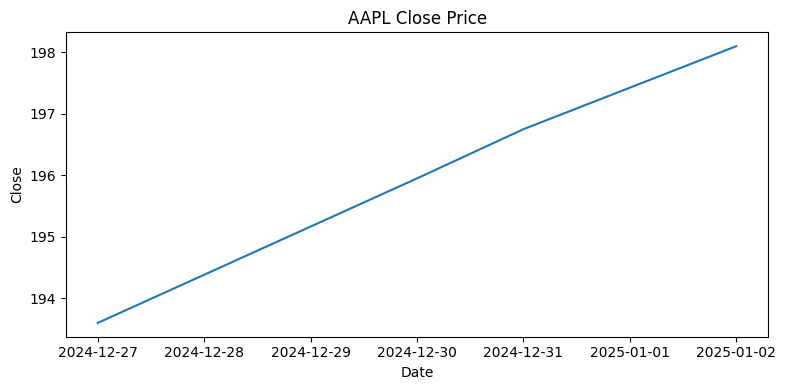

In [8]:
plt.figure(figsize=(8,4))
plt.plot(df_all['Date'], df_all['Close'])
plt.title('AAPL Close Price')
plt.xlabel('Date')
plt.ylabel('Close')
plt.tight_layout()
plt.show()

## Step 7 — Power BI (load Parquet)
1. Open **Power BI Desktop**.
2. Go to *Get Data* → *Parquet*.
3. Select `mart/ohlcv_features.parquet`.
4. Load data, set column types.
5. Build a quick Date vs Close chart.

In [2]:
from pathlib import Path
p = Path("mart/ohlcv_features.parquet").resolve()
print(p)
print("Exists:", p.exists())

C:\Users\TJs PC\OneDrive\Desktop\Finance Data OS\mart\ohlcv_features.parquet
Exists: True
